In [ ]:
%%capture

!pip install --upgrade pandas-datareader
!pip install ffn backtesting

## 選股策略
### 交易量夠大、股價穩定(Beta值小於1)、且基本面良好的標的，因此選擇 【2376 技嘉】作為本次作業的回測標的。


<font color='purple'>以下將使用2022-01-01至今的數據進行回測，顯示從18000點下探至13000點又回到18000點的景氣循環歷史資料。</font>

## 2376.tw Info

In [1]:
import ffn

tbl = ffn.get("2376.tw", start = "2022-01-01")

tbl

C:\Users\USER\anaconda3\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


,2376tw
Date,
2022-01-03,133.311050
2022-01-04,129.903732
2022-01-05,131.181488
2022-01-06,131.607391
2022-01-07,125.644592
...,...
2024-02-19,366.500000
2024-02-20,357.000000
2024-02-21,347.500000


<AxesSubplot:xlabel='Date'>

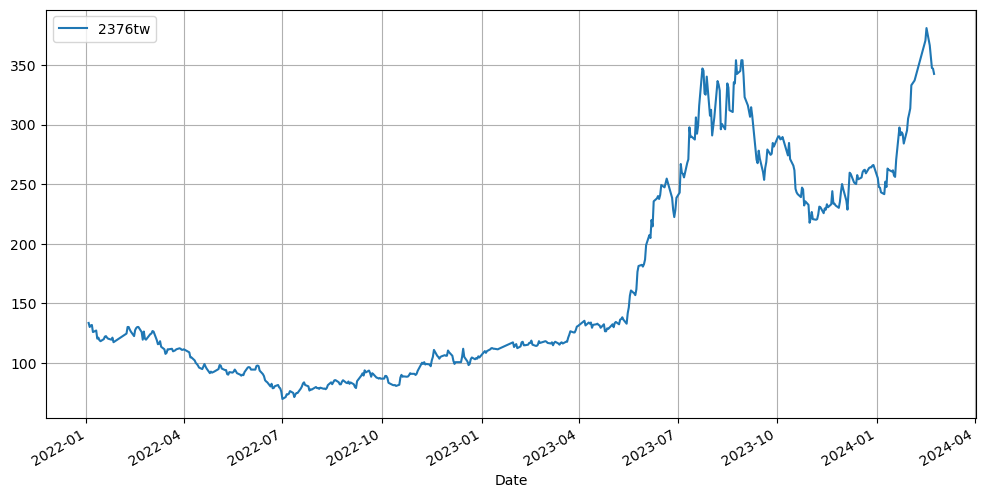

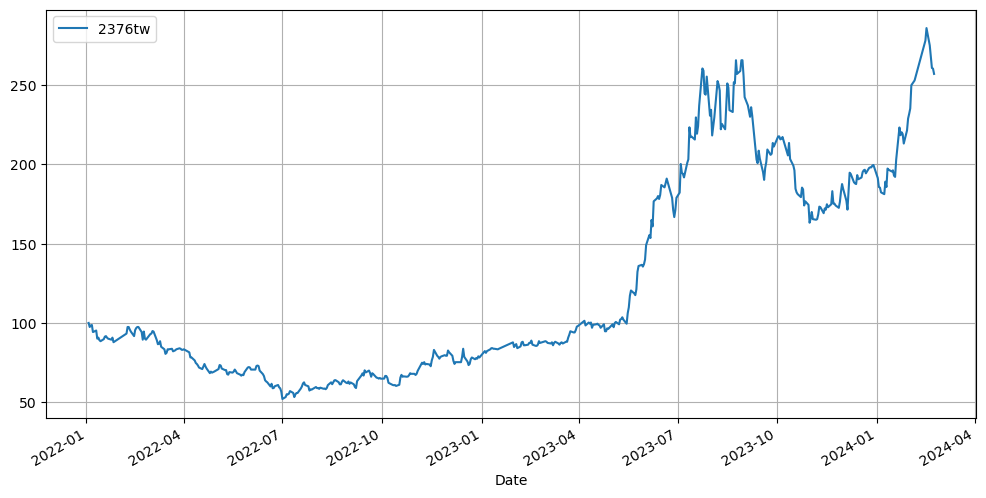

In [2]:
%matplotlib inline

tbl.plot.line(grid = True, figsize = (12, 6))

# rebased

tbl.rebase().plot.line(grid = True, figsize = (12, 6))

<AxesSubplot:ylabel='Frequency'>

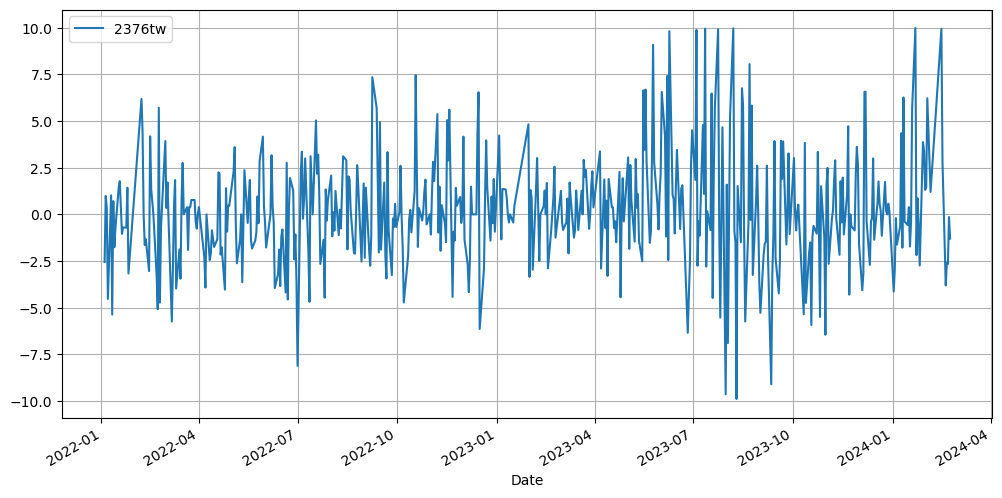

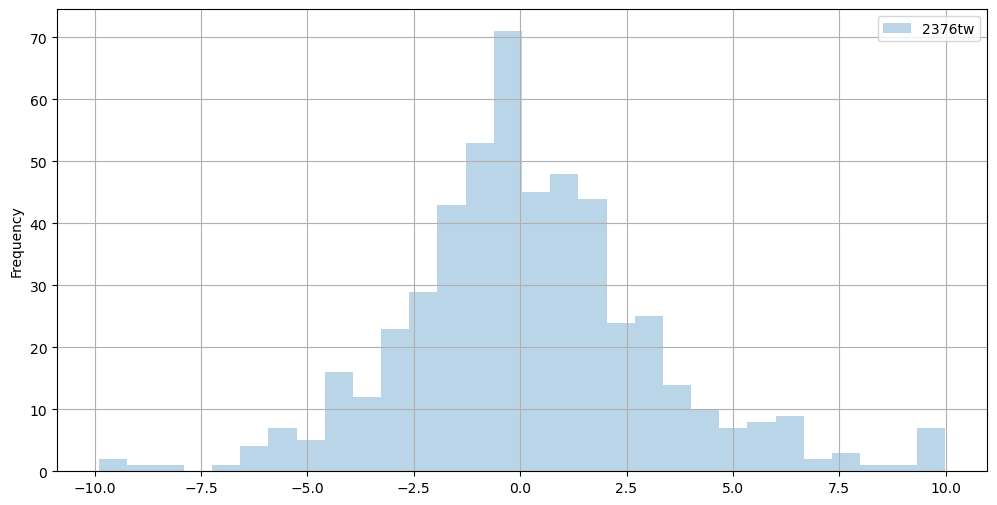

In [3]:
return_rates = tbl.pct_change() * 100
return_rates.plot.line(grid = True, figsize = (12, 6))

return_rates.plot.hist(bins = 30, alpha = 0.3, grid = True, figsize = (12, 6))

In [4]:
tbl.calc_stats().display()

Stat                 2376tw
-------------------  ----------
Start                2022-01-03
End                  2024-02-23
Risk-free rate       0.00%

Total Return         156.92%
Daily Sharpe         1.20
Daily Sortino        2.25
CAGR                 55.47%
Max Drawdown         -47.92%
Calmar Ratio         1.16

MTD                  10.84%
3m                   46.68%
6m                   2.39%
YTD                  28.76%
1Y                   190.29%
3Y (ann.)            55.47%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  55.47%

Daily Sharpe         1.20
Daily Sortino        2.25
Daily Mean (ann.)    57.33%
Daily Vol (ann.)     47.58%
Daily Skew           0.38
Daily Kurt           1.38
Best Day             9.98%
Worst Day            -9.89%

Monthly Sharpe       1.22
Monthly Sortino      2.59
Monthly Mean (ann.)  66.01%
Monthly Vol (ann.)   53.95%
Monthly Skew         0.18
Monthly Kurt         0.49
Best Month           42.37%
Worst Month          -22.74%

Yearly

## Signals

,2376tw,SMA5,SMA10
Date,,,
2022-01-03,133.311050,NaN,NaN
2022-01-04,129.903732,NaN,NaN
2022-01-05,131.181488,NaN,NaN
2022-01-06,131.607391,NaN,NaN
2022-01-07,125.644592,130.329651,NaN
...,...,...,...
2024-02-19,366.500000,357.600000,329.45
2024-02-20,357.000000,362.400000,336.75
2024-02-21,347.500000,364.500000,342.00


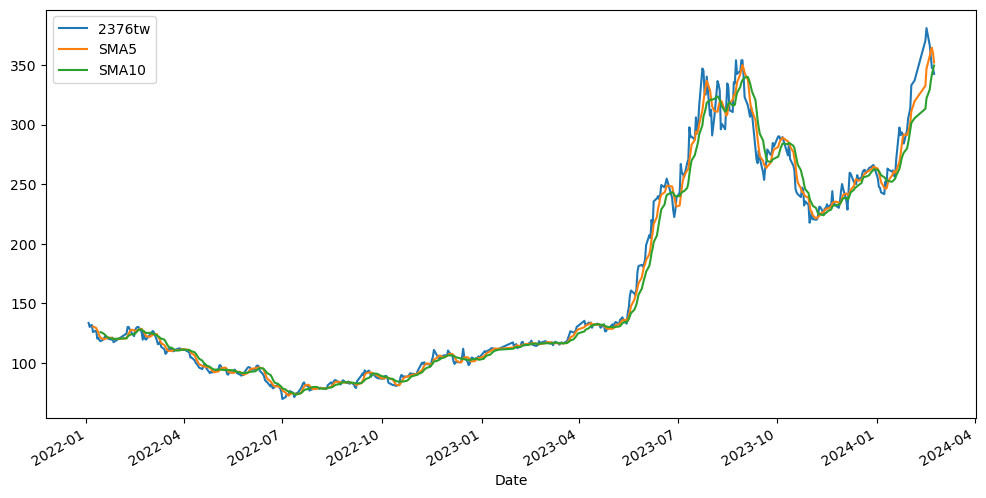

In [5]:
from ffn.utils import clean_ticker

target = "2376.tw"
name = clean_ticker(target)
asset = ffn.get(target, start = "2022-01-01")


asset["SMA5"] = asset[name].rolling(5).mean()
asset["SMA10"] = asset[name].rolling(10).mean()

asset
asset.plot.line(figsize = (12,6))

asset

In [6]:
buy_signal_mask = (asset["SMA5"].shift(2) < asset["SMA10"].shift(2)) & (asset["SMA5"].shift(1) > asset["SMA10"].shift(1))
buy_signal_mask

Date
2022-01-03    False
2022-01-04    False
2022-01-05    False
2022-01-06    False
2022-01-07    False
              ...  
2024-02-19    False
2024-02-20    False
2024-02-21    False
2024-02-22    False
2024-02-23    False
Length: 517, dtype: bool

In [7]:
sell_signal_mask = (asset["SMA5"].shift(2) > asset["SMA10"].shift(2)) & (asset["SMA5"].shift(1) < asset["SMA10"].shift(1))

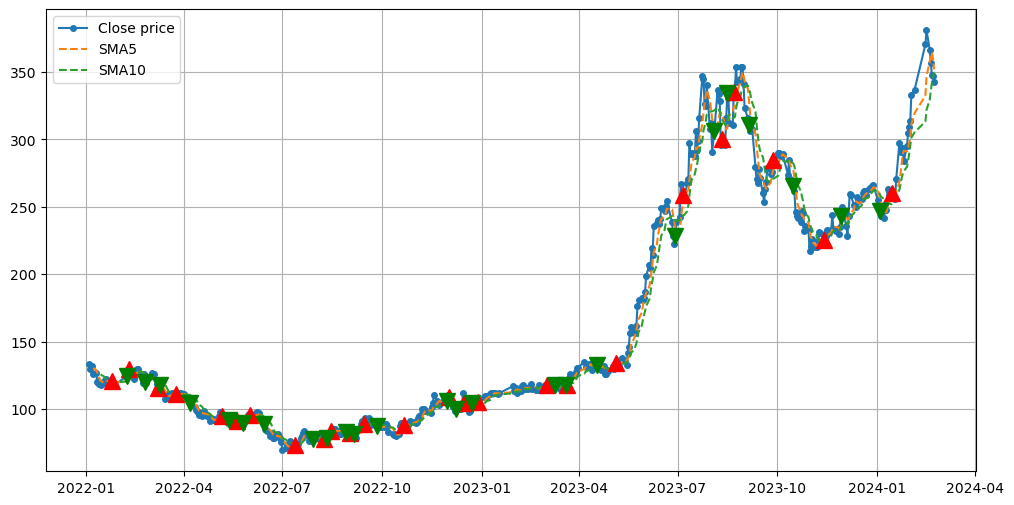

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.plot(asset[name], ".-", markersize = 8)
plt.plot(asset["SMA5"], linestyle = "--")
plt.plot(asset["SMA10"], linestyle = "--")
plt.plot(asset[name][buy_signal_mask], "r^", markersize = 12)
plt.plot(asset[name][sell_signal_mask], "gv", markersize = 12)
plt.grid(True)
plt.legend(["Close price", "SMA5", "SMA10"])

## 交易策略說明：

SMA5與SMA10的交叉買賣訊號分析，產生買進訊號時買入，則產生賣出訊號時平倉，不做空單，最後以夏普指數為最大值找出最穩定的N1&N2參數進行策略最佳化，並參考SQN評價該交易系統。

<img src = "https://3.bp.blogspot.com/-iKaU7j_yMjo/UoTQDVqufmI/AAAAAAAAAq8/dA1EkBZ07X4/s400/2013-11-14_203502.png" width = "300px"/>

In [9]:
import ffn

testee = ffn.get("2376.tw:Open, 2376.tw:High, 2376.tw:Low, 2376.tw:Close", start = "2022-01-01")
testee.columns = list(map(lambda x : x[6:].title(), testee.columns))
testee

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2022-01-03,156.5,157.5,152.5,156.5
2022-01-04,157.0,160.0,152.0,152.5
2022-01-05,152.5,155.0,151.0,154.0
2022-01-06,151.0,156.5,149.0,154.5
2022-01-07,154.5,154.5,145.0,147.5
...,...,...,...,...
2024-02-19,369.5,379.5,361.0,366.5
2024-02-20,364.5,366.0,348.0,357.0
2024-02-21,350.0,354.5,344.0,347.5


In [10]:
from backtesting import Backtest, Strategy
from backtesting.test import SMA
from backtesting.lib import crossover

class SmaCross(Strategy):

    n1 = 5
    n2 = 10

    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, self.n1)
        self.ma2 = self.I(SMA, price, self.n2)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy() 
        elif crossover(self.ma2, self.ma1):
            self.position.close()

C:\Users\USER\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [11]:
bt = Backtest(testee, SmaCross, commission = .005, cash = 100000, exclusive_orders = True)
stats = bt.run()
bt.plot()

Row(id='1393', ...)

In [12]:
stats

Start                     2022-01-03 00:00:00
End                       2024-02-23 00:00:00
Duration                    781 days 00:00:00
Exposure Time [%]                   61.702128
Equity Final [$]                253880.302202
Equity Peak [$]                 270187.302202
Return [%]                         153.880302
Buy & Hold Return [%]               118.84984
Return (Ann.) [%]                   57.480684
Volatility (Ann.) [%]               58.341372
Sharpe Ratio                         0.985247
Sortino Ratio                        2.705133
Calmar Ratio                         1.883031
Max. Drawdown [%]                   -30.52562
Avg. Drawdown [%]                   -7.184922
Max. Drawdown Duration      457 days 00:00:00
Avg. Drawdown Duration       55 days 00:00:00
# Trades                                   23
Win Rate [%]                        47.826087
Best Trade [%]                      69.846737
Worst Trade [%]                    -15.308951
Avg. Trade [%]                    

In [13]:
stats["_trades"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,652,20,31,153.262500,144.500000,-5713.150000,-0.057173,2022-02-09,2022-02-24,15 days
1,694,38,40,135.675000,140.000000,3001.550000,0.031878,2022-03-08,2022-03-10,2 days
2,738,51,78,131.655000,111.500000,-14874.390000,-0.153090,2022-03-25,2022-05-06,42 days
3,735,78,83,112.057500,106.500000,-4084.762500,-0.049595,2022-05-06,2022-05-13,7 days
4,711,88,92,110.047500,106.000000,-2877.772500,-0.036780,2022-05-20,2022-05-26,6 days
5,667,96,104,113.062500,104.500000,-5711.187500,-0.075732,2022-06-01,2022-06-14,13 days
6,807,125,137,86.329502,92.000000,4576.092262,0.065684,2022-07-13,2022-07-29,16 days
7,867,151,158,85.625997,85.000000,-542.739341,-0.007311,2022-08-18,2022-08-29,11 days
8,860,161,163,85.726503,85.099998,-538.793950,-0.007308,2022-09-01,2022-09-05,4 days
9,810,169,177,90.349502,91.400002,850.904994,0.011627,2022-09-14,2022-09-26,12 days


In [14]:
stats2 = bt.optimize(n1 = range(5, 60, 5), n2 = range(10, 240, 10), maximize = 'Sharpe Ratio',
           constraint = lambda param: param.n1 < param.n2)
stats2._strategy

  0%|          | 0/18 [00:00<?, ?it/s]

<Strategy SmaCross(n1=40,n2=60)>

In [15]:
stats2 

Start                     2022-01-03 00:00:00
End                       2024-02-23 00:00:00
Duration                    781 days 00:00:00
Exposure Time [%]                   50.676983
Equity Final [$]                506001.129869
Equity Peak [$]                 538500.129869
Return [%]                          406.00113
Buy & Hold Return [%]               118.84984
Return (Ann.) [%]                  120.405676
Volatility (Ann.) [%]               86.428431
Sharpe Ratio                         1.393126
Sortino Ratio                        5.727768
Calmar Ratio                         4.226435
Max. Drawdown [%]                  -28.488706
Avg. Drawdown [%]                   -4.962144
Max. Drawdown Duration      191 days 00:00:00
Avg. Drawdown Duration       18 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                      252.40465
Worst Trade [%]                     43.636655
Avg. Trade [%]                    

In [16]:
stats2["_trades"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1219,191,422,82.007998,289.0,252323.249869,2.524047,2022-10-17,2023-10-02,350 days
1,1413,487,516,249.240000,358.0,153677.880000,0.436367,2024-01-04,2024-02-23,50 days


## 最佳化結果
### 以【SmaCross, n1=40, n2=60】的參數設定交易策略為最佳，獲利可達406%；則SQN值可達4.1157，但因為交易次數少於10次，因此SQN的參考價值並不高。

### 本策略獲利高於 buy and hold，是一個相對穩定且勝率高的投資策略。

## 績效報告

In [17]:
position = False
asset["PV"] = 0.0
turnovers = 0

for i, t in enumerate(asset.index):
    
    if not position:
        
        payoff = 0
        asset["PV"].iloc[i] = asset["PV"].iloc[i - 1] + payoff
        
        if buy_signal_mask[t]:
            position = True
            turnovers = turnovers + 1
            print(">" * 5, "Create a long position.")
    else:
        
        payoff = asset[name].iloc[i] - asset[name].iloc[i - 1]
        asset["PV"].iloc[i] = asset["PV"].iloc[i - 1] + payoff
       
        if sell_signal_mask[t]:
            position = False
            print("<" * 5, "Close a long position.")
            print("{} -> {:.2f} -> {:.2f}".format(t, asset[name][t], asset["PV"][t]))

print("Number of turnovers:", turnovers)

>>>>> Create a long position.
<<<<< Close a long position.
2022-02-07 00:00:00 -> 124.37 -> 3.41
>>>>> Create a long position.
<<<<< Close a long position.
2022-02-24 00:00:00 -> 120.11 -> -6.39
>>>>> Create a long position.
<<<<< Close a long position.
2022-03-10 00:00:00 -> 117.98 -> -3.83
>>>>> Create a long position.
<<<<< Close a long position.
2022-04-07 00:00:00 -> 104.35 -> -10.65
>>>>> Create a long position.
<<<<< Close a long position.
2022-05-13 00:00:00 -> 92.00 -> -13.63
>>>>> Create a long position.
<<<<< Close a long position.
2022-05-26 00:00:00 -> 89.44 -> -15.33
>>>>> Create a long position.
<<<<< Close a long position.
2022-06-14 00:00:00 -> 88.59 -> -22.57
>>>>> Create a long position.
<<<<< Close a long position.
2022-07-29 00:00:00 -> 77.86 -> -17.97
>>>>> Create a long position.
<<<<< Close a long position.
2022-08-11 00:00:00 -> 78.62 -> -17.39
>>>>> Create a long position.
<<<<< Close a long position.
2022-08-29 00:00:00 -> 83.03 -> -17.78
>>>>> Create a long 

In [18]:
asset["MDD (Ours)"] = (asset["PV"] - asset["PV"].cummax()).cummin()
dd_idx = asset["MDD (Ours)"].idxmin()
asset["Buy&Hold"] = asset[name].diff().cumsum()
asset["MDD (Buy&Hold)"] = (asset["Buy&Hold"] - asset["Buy&Hold"].cummax()).cummin()
dd_idx2 = asset["MDD (Buy&Hold)"].idxmin()

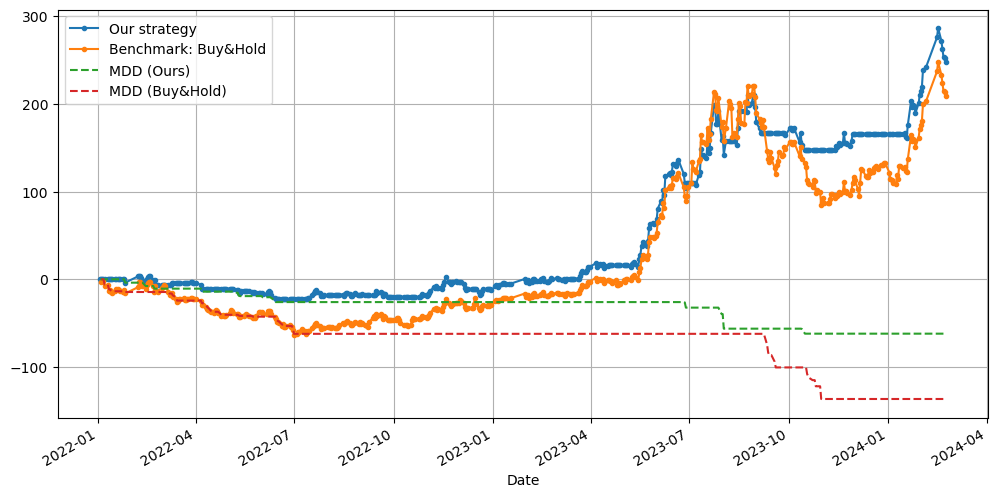

In [19]:
asset[["PV", "Buy&Hold"]].plot(style = ".-", grid = True, figsize = (12, 6))
ax = asset["MDD (Ours)"].plot(style = "--", grid = True)
ax = asset["MDD (Buy&Hold)"].plot(style = "--", grid = True)
ax.legend(["Our strategy", "Benchmark: Buy&Hold", "MDD (Ours)", "MDD (Buy&Hold)"])